In [34]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt



In [ ]:
# Parameters
M_0 = 0.1
M_eq = 0.02
N_x = 50  
dx = L / (N_x - 1)
D = 1.0e-9     
L = 0.01       
h = 0.005       
x_grid = np.linspace(0, L, N_x)
dt = 10 * (dx**2) / D  #Fourier con Alpha=10
print(f"Paso de tiempo calculado: {dt} segundos")
N_t = 2000




Paso de tiempo calculado: 416.49312786339027 segundos


In [36]:
def Crank_Nicolson_step(A, B, beta, u_prev):
    
    b = B @ u_prev; b[-1] = beta

    # Solve A @ u_next = B @ u_prev
    u_next = sp.linalg.spsolve(A, b)

    return u_next

def simulate_diffusion(M_0, M_eq, D, L, N_x, dt, N_t, h, sparse_format = 'csc'):
    dx = L / (N_x - 1)
    alpha = D * dt / dx**2
    beta = 2 * dx * h * M_eq / D

    # Construct matrices A and B

    A1 = sp.eye(N_x, k = 0, format=sparse_format) * (2*(1 + alpha))
    A2 = sp.eye(N_x, k = -1, format=sparse_format) * -alpha
    A3 = sp.eye(N_x, k = 1, format=sparse_format) * -alpha
    A = A1 + A2 + A3
    
    # Boundary condition at x = 0
    A[0, 0] = -3; A[0, 1] = 4; A[0, 2] = -1

    # Boundary condition at x = L
    A[-1, -1] = 3 + 2 * dx * h / D; A[-1, -2] = -4; A[-1, -3] = 1

    B1 = sp.eye(N_x, k = 0, format=sparse_format) * (2*(1 - alpha))
    B2 = sp.eye(N_x, k = -1, format=sparse_format) * alpha
    B3 = sp.eye(N_x, k = 1, format=sparse_format) * alpha
    B = B1 + B2 + B3
    B[0, 0] = 0; B[0, 1] = 0; B[-1, -1] = 0; B[-1, -2] = 0

    print(alpha)

    # Initial condition
    u = np.ones(N_x) * M_0

    # Store results
    # results = [u.copy()]
    results = np.zeros((N_t + 1, N_x))
    results[0, :] = u.copy()


    for n in range(N_t):
        u = Crank_Nicolson_step(A, B, beta, u)
        # results.append(u.copy())
        results[n + 1, :] = u.copy()

    return np.array(results)

In [37]:
u_history = simulate_diffusion(M_0, M_eq, D, L, N_x, dt, N_t, h)

9.999999999999998


C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


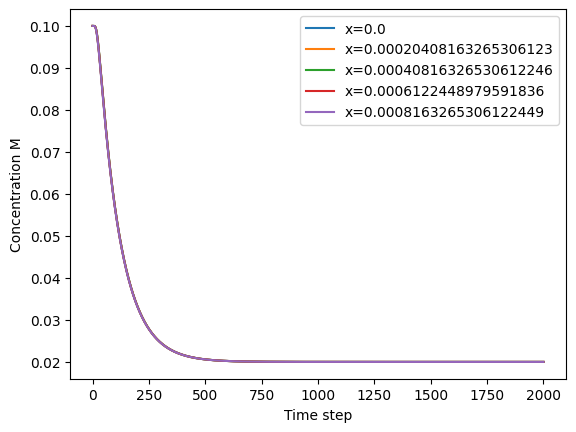

In [38]:
for i in range(5):
    plt.plot(u_history[:, i], label=f'x={x_grid[i]}')

# plt.plot(u_history[:, 0], label='x=0')
# plt.plot(u_history[:, N_x // 2], label='x=L/2')
# plt.plot(u_history[:, -1], label='x=L')
plt.xlabel('Time step')
plt.ylabel('Concentration M')
plt.legend()
plt.show()

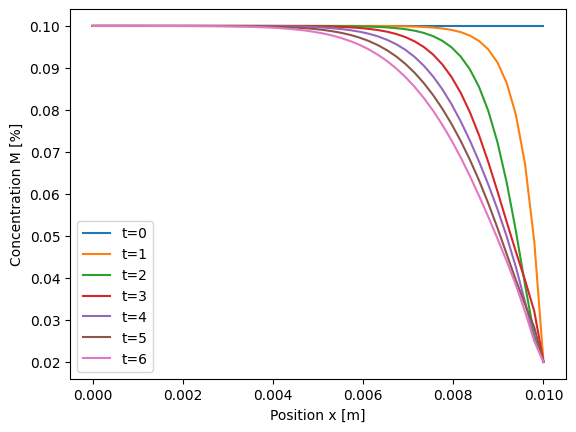

In [39]:
for i in range(7):
    plt.plot(x_grid, u_history[i, :], label=f't={i}')
# plt.plot(x_grid, u_history[0, :], label=f't=0')

# plt.plot(x_grid, u_history[N_t // 2, :], label='t=T/2')
# plt.plot(x_grid, u_history[-1, :], label='t=T')
plt.xlabel('Position x [m]')
plt.ylabel('Concentration M [%]')
plt.legend()
plt.show()

## Problema:
La solución se va a cero muy rápido, puede que esté usando parámetros con poco sentido físico.

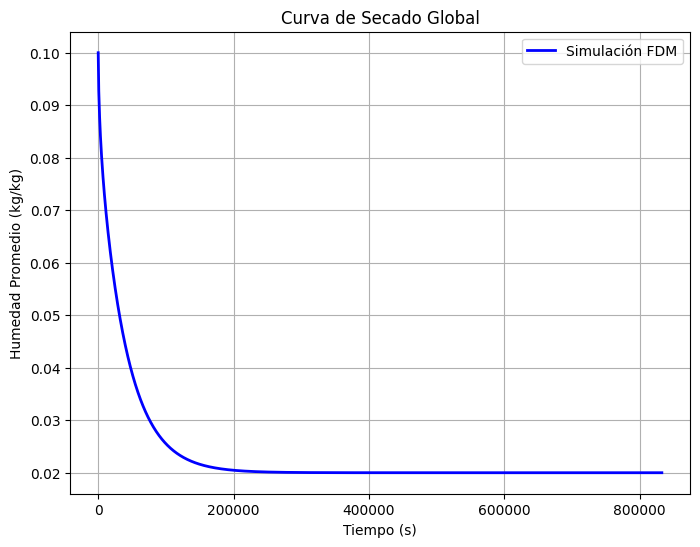

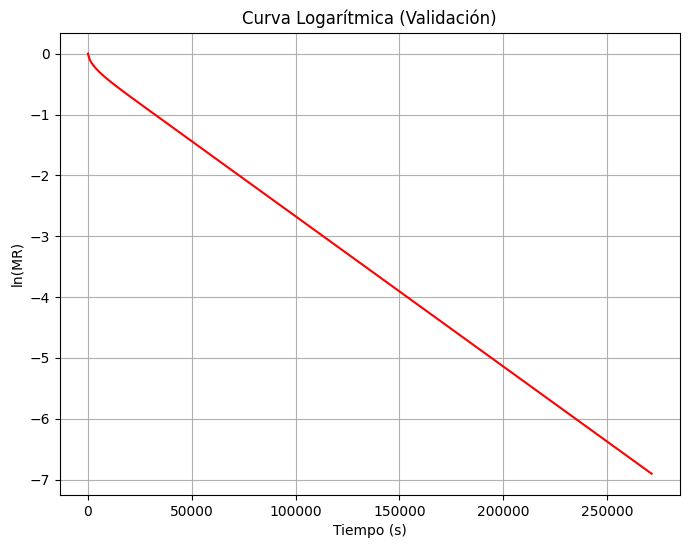

In [40]:
M_average = (np.sum(u_history, axis=1) - 0.5*u_history[:,0] - 0.5*u_history[:,-1]) / (N_x - 1) # Regla del trapecio
 

time_vector = np.arange(len(M_average)) * dt

plt.figure(figsize=(8, 6))
plt.plot(time_vector, M_average, 'b-', linewidth=2, label='Simulación FDM')
plt.xlabel('Tiempo (s)')
plt.ylabel('Humedad Promedio (kg/kg)')
plt.title('Curva de Secado Global')
plt.grid(True)
plt.legend()
plt.show()

MR = (M_average - M_eq) / (M_0 - M_eq) # Arranaza -->MR = (M_t - M_eq) / (M_0 - M_eq)

valid_mask = MR > 0.001
ln_MR = np.log(MR[valid_mask])
time_log = time_vector[valid_mask]

plt.figure(figsize=(8, 6))
plt.plot(time_log, ln_MR, 'r-')
plt.xlabel('Tiempo (s)')
plt.ylabel('ln(MR)')
plt.title('Curva Logarítmica (Validación)')
plt.grid(True)
plt.show()

In [41]:
from scipy.stats import linregress

mitad = len(time_log) // 2 #regresión solo en la parte recta

t_cola = time_log[mitad:]
ln_MR_cola = ln_MR[mitad:]

slope, intercept, r_value, p_value, std_err = linregress(t_cola, ln_MR_cola)

print("=== RESULTADOS DE LA VALIDACIÓN (ARRANZA) ===")
print(f"Pendiente (b): {slope:.6f}")
print(f"Intercepto (a): {intercept:.6f}")
print(f"R-cuadrado: {r_value**2:.6f}")


=== RESULTADOS DE LA VALIDACIÓN (ARRANZA) ===
Pendiente (b): -0.000025
Intercepto (a): -0.205005
R-cuadrado: 1.000000
